In [198]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [199]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [200]:
import numpy as np
import pandas as pd
import os
import math
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import warnings
import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import RobertaTokenizer, TFRobertaModel

warnings.filterwarnings("ignore")

In [201]:


# Set up the TPU or GPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU:', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()
    print('Running on GPU:', strategy.num_replicas_in_sync)


Running on GPU: 1


In [202]:
import os


In [203]:

# Constants
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
#ARTIFACTS_PATH = '../artifacts/'
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

#if not os.path.exists(ARTIFACTS_PATH):
#    os.makedirs(ARTIFACTS_PATH)

In [204]:
import pandas as pd


In [ ]:
# Read the new dataset from livex.csv

import pandas as pd

dfa = pd.read_csv('C:/Users/../livedx_T_AI_1.csv')
columns = dfa.columns.tolist()
print(columns)


['Text', 'Task1', 'Task2', 'Task3', 'Task4', 'Task5', 'Task6', 'Task7', 'Task8', 'Task9', 'Task10', 'Task11', 'Task12', 'Task13', 'Task14', 'Task15']


In [206]:
import numpy as np


In [207]:

# Replace NaN values with a default value (e.g., -1) or any other appropriate value
#df.fillna(-1, inplace=True)



# Split the dataset into X_data (text) and task labels (Task1 to Task14)
X_data = dfa['Text'].values
task_labels = dfa.iloc[:, 1:].values.astype('int32')


In [208]:
import matplotlib.pyplot as plt


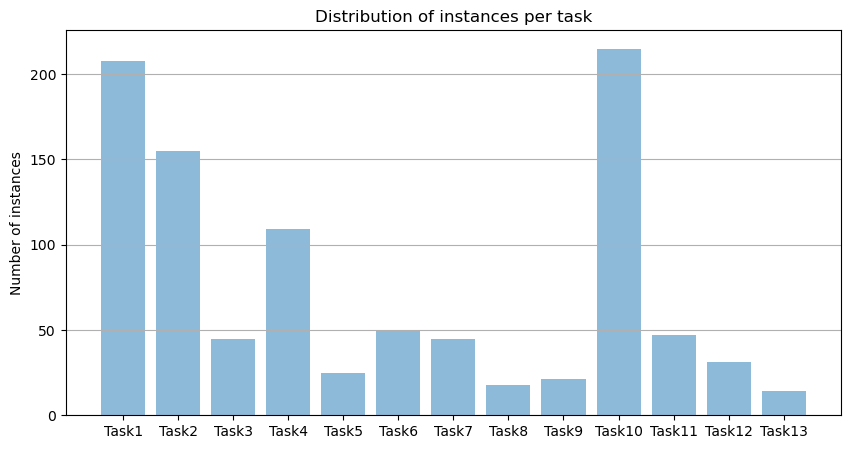

In [209]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'task_labels' is a NumPy ndarray containing the task labels
task_labels_sum = np.sum(task_labels[:, :13], axis=0)
task_names = ['Task' + str(i) for i in range(1, 14)]

plt.figure(figsize=(10, 5))
plt.bar(task_names, task_labels_sum, align='center', alpha=0.5)
plt.ylabel('Number of instances')
plt.title('Distribution of instances per task')
plt.gca().yaxis.grid(True)
plt.show()


In [230]:
# Assuming 'task_labels' is a NumPy ndarray containing the task labels
task_labels_sum = np.sum(task_labels[:, :15], axis=0)
task_names = ['Task' + str(i) for i in range(1, 16)]

In [231]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, task_labels, test_size=0.3, random_state=777)

In [232]:
from transformers import RobertaTokenizer


# Initialize the Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

# Encode the text data using the tokenizer
def roberta_encode(texts, tokenizer):
    input_ids = np.ones((len(texts), MAX_LEN), dtype='int32')
    attention_mask = np.zeros((len(texts), MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((len(texts), MAX_LEN), dtype='int32')

    for i, text in enumerate(texts):
        tokens = tokenizer.tokenize(text)
        tokens = tokens[:MAX_LEN-2]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        input_ids[i, :len(tokens)] = tokenizer.convert_tokens_to_ids(tokens)
        attention_mask[i, :len(tokens)] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }


In [233]:
import numpy as np

In [234]:


# Encode the train and test data
X_train_encoded = roberta_encode(X_train, tokenizer)
X_test_encoded = roberta_encode(X_test, tokenizer)


In [235]:

# Define the Multitask Roberta model
def build_model():
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        roberta = TFRobertaModel.from_pretrained(MODEL_NAME)
        roberta.resize_token_embeddings(len(tokenizer))

        sequence_output = roberta(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)[0]
        cls_token = sequence_output[:, 0, :]

        task_outputs = []
        for i in range(15):
            task_outputs.append(tf.keras.layers.Dense(1, activation='sigmoid', name=f'task_output_{i+1}')(cls_token))

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=task_outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
        
    return model

In [236]:
!pip install --upgrade tensorflow
!pip install --upgrade keras
!pip install --upgrade transformers


In [237]:
import tensorflow as tf
import keras
import transformers

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Transformers version:", transformers.__version__)


TensorFlow version: 2.12.0
Keras version: 2.12.0
Transformers version: 4.30.2


In [238]:
!pip install --upgrade transformers


In [239]:
import transformers

print("Transformers version:", transformers.__version__)


Transformers version: 4.30.2


In [240]:
from transformers import TFRobertaModel


In [241]:


# Train and evaluate the model
model = build_model()
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_11 (TFRoberta  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 Model)                         thPoolingAndCrossAt               'input_mask[0][0]',      

In [242]:

history = model.fit(
    X_train_encoded, list(y_train.T),
    validation_data=(X_test_encoded, list(y_test.T)),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Evaluate model performance on test data
test_predictions = model.predict(X_test_encoded)
test_predictions = [np.round(pred.flatten()) for pred in test_predictions]
test_accuracy = [accuracy_score(y_test[:, i], test_predictions[i]) for i in range(15)]

print('Test Accuracy per Task:')
for i, acc in enumerate(test_accuracy):
    print(f'Task {i+1}: {acc}')


Epoch 1/3


88/88 [==============================] - 1853s 21s/step - loss: 4.7234 - task_output_1_loss: 0.6016 - task_output_2_loss: 0.4891 - task_output_3_loss: 0.2233 - task_output_4_loss: 0.4014 - task_output_5_loss: 0.1615 - task_output_6_loss: 0.2625 - task_output_7_loss: 0.1938 - task_output_8_loss: 0.1138 - task_output_9_loss: 0.1368 - task_output_10_loss: 0.5873 - task_output_11_loss: 0.2660 - task_output_12_loss: 0.1617 - task_output_13_loss: 0.0869 - task_output_14_loss: 0.7259 - task_output_15_loss: 0.3118 - task_output_1_accuracy: 0.7339 - task_output_2_accuracy: 0.8326 - task_output_3_accuracy: 0.9399 - task_output_4_accuracy: 0.8641 - task_output_5_accuracy: 0.9599 - task_output_6_accuracy: 0.9299 - task_output_7_accuracy: 0.9557 - task_output_8_accuracy: 0.9599 - task_output_9_accuracy: 0.9714 - task_output_10_accuracy: 0.7668 - task_output_11_accuracy: 0.9356 - task_output_12_accuracy: 0.9742 - task_output_13_accuracy: 0.9828 - task_output_14_accuracy: 0.5866 - task_output_15_accu

In [264]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Calculating metrics - precision, recall, and F1 score for each task
precision = []
recall = []
f1_measure = []

for i in range(1, 16):  # Iterate from 1 to 14
    task_precision = precision_score(y_test, np.round(test_predictions), average=None)
    task_recall = recall_score(y_test, np.round(test_predictions), average=None)
    task_f1 = f1_score(y_test, np.round(test_predictions), average=None)
    
    precision.append(task_precision)
    recall.append(task_recall)
    f1_measure.append(task_f1)

# Print precision, recall, and F1 score for each task
print('Precision per Task:')
for i, p in enumerate(precision):
    print(f'Task {i+1}: {p}')
    
print('Recall per Task:')
for i, r in enumerate(recall):
    print(f'Task {i+1}: {r}')
    
print('F1 Score per Task:')
for i, f in enumerate(f1_measure):
    print(f'Task {i+1}: {f}')


Precision per Task:
Task 1: [0.85238095 0.17333333]
Task 2: [0.85238095 0.17333333]
Task 3: [0.85238095 0.17333333]
Task 4: [0.85238095 0.17333333]
Task 5: [0.85238095 0.17333333]
Task 6: [0.85238095 0.17333333]
Task 7: [0.85238095 0.17333333]
Task 8: [0.85238095 0.17333333]
Task 9: [0.85238095 0.17333333]
Task 10: [0.85238095 0.17333333]
Task 11: [0.85238095 0.17333333]
Task 12: [0.85238095 0.17333333]
Task 13: [0.85238095 0.17333333]
Task 14: [0.85238095 0.17333333]
Task 15: [0.85238095 0.17333333]
Recall per Task:
Task 1: [0.93521421 0.07738095]
Task 2: [0.93521421 0.07738095]
Task 3: [0.93521421 0.07738095]
Task 4: [0.93521421 0.07738095]
Task 5: [0.93521421 0.07738095]
Task 6: [0.93521421 0.07738095]
Task 7: [0.93521421 0.07738095]
Task 8: [0.93521421 0.07738095]
Task 9: [0.93521421 0.07738095]
Task 10: [0.93521421 0.07738095]
Task 11: [0.93521421 0.07738095]
Task 12: [0.93521421 0.07738095]
Task 13: [0.93521421 0.07738095]
Task 14: [0.93521421 0.07738095]
Task 15: [0.93521421 0.0

In [249]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each task
precision = []
recall = []
f1_measure = []

for i in range(15):
    task_precision = precision_score(y_test[:, i], np.round(test_predictions[i]), average='micro')
    task_recall = recall_score(y_test[:, i], np.round(test_predictions[i]), average='micro')
    task_f1 = f1_score(y_test[:, i], np.round(test_predictions[i]), average='micro')
    
    precision.append(task_precision)
    recall.append(task_recall)
    f1_measure.append(task_f1)

# Print precision, recall, and F1 score for each task
print('Precision per Task:')
for i, p in enumerate(precision):
    print(f'Task {i+1}: {p}')
    
print('Recall per Task:')
for i, r in enumerate(recall):
    print(f'Task {i+1}: {r}')
    
print('F1 Score per Task:')
for i, f in enumerate(f1_measure):
    print(f'Task {i+1}: {f}')


Precision per Task:
Task 1: 0.78
Task 2: 0.84
Task 3: 0.97
Task 4: 0.9
Task 5: 0.98
Task 6: 0.95
Task 7: 0.95
Task 8: 0.98
Task 9: 0.98
Task 10: 0.7766666666666666
Task 11: 0.9666666666666667
Task 12: 0.9566666666666667
Task 13: 0.9833333333333333
Task 14: 0.66
Task 15: 0.9133333333333333
Recall per Task:
Task 1: 0.78
Task 2: 0.84
Task 3: 0.97
Task 4: 0.9
Task 5: 0.98
Task 6: 0.95
Task 7: 0.95
Task 8: 0.98
Task 9: 0.98
Task 10: 0.7766666666666666
Task 11: 0.9666666666666667
Task 12: 0.9566666666666667
Task 13: 0.9833333333333333
Task 14: 0.66
Task 15: 0.9133333333333333
F1 Score per Task:
Task 1: 0.78
Task 2: 0.8399999999999999
Task 3: 0.97
Task 4: 0.9
Task 5: 0.98
Task 6: 0.9500000000000001
Task 7: 0.9500000000000001
Task 8: 0.98
Task 9: 0.98
Task 10: 0.7766666666666666
Task 11: 0.9666666666666667
Task 12: 0.9566666666666667
Task 13: 0.9833333333333333
Task 14: 0.66
Task 15: 0.9133333333333333


In [252]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each task
precision = []
recall = []
f1_measure = []

for i in range(15):
    task_precision = precision_score(y_test[:, i], np.round(test_predictions[i]), average='macro')
    task_recall = recall_score(y_test[:, i], np.round(test_predictions[i]), average='macro')
    task_f1 = f1_score(y_test[:, i], np.round(test_predictions[i]), average='macro')
    
    precision.append(task_precision)
    recall.append(task_recall)
    f1_measure.append(task_f1)

# Print precision, recall, and F1 score for each task
print('Precision per Task:')
for i, p in enumerate(precision):
    print(f'Task {i+1}: {p}')
    
print('Recall per Task:')
for i, r in enumerate(recall):
    print(f'Task {i+1}: {r}')
    
print('F1 Score per Task:')
for i, f in enumerate(f1_measure):
    print(f'Task {i+1}: {f}')


Precision per Task:
Task 1: 0.39
Task 2: 0.42
Task 3: 0.485
Task 4: 0.45
Task 5: 0.49
Task 6: 0.475
Task 7: 0.475
Task 8: 0.49
Task 9: 0.49
Task 10: 0.3883333333333333
Task 11: 0.48333333333333334
Task 12: 0.47833333333333333
Task 13: 0.49166666666666664
Task 14: 0.33
Task 15: 0.45666666666666667
Recall per Task:
Task 1: 0.5
Task 2: 0.5
Task 3: 0.5
Task 4: 0.5
Task 5: 0.5
Task 6: 0.5
Task 7: 0.5
Task 8: 0.5
Task 9: 0.5
Task 10: 0.5
Task 11: 0.5
Task 12: 0.5
Task 13: 0.5
Task 14: 0.5
Task 15: 0.5
F1 Score per Task:
Task 1: 0.43820224719101125
Task 2: 0.4565217391304348
Task 3: 0.49238578680203043
Task 4: 0.4736842105263158
Task 5: 0.494949494949495
Task 6: 0.48717948717948717
Task 7: 0.48717948717948717
Task 8: 0.494949494949495
Task 9: 0.494949494949495
Task 10: 0.4371482176360225
Task 11: 0.4915254237288135
Task 12: 0.48892674616695064
Task 13: 0.49579831932773105
Task 14: 0.39759036144578314
Task 15: 0.47735191637630664


In [253]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each task
precision = []
recall = []
f1_measure = []

for i in range(15):
    task_precision = precision_score(y_test[:, i], np.round(test_predictions[i]), average='weighted')
    task_recall = recall_score(y_test[:, i], np.round(test_predictions[i]), average='weighted')
    task_f1 = f1_score(y_test[:, i], np.round(test_predictions[i]), average='weighted')
    
    precision.append(task_precision)
    recall.append(task_recall)
    f1_measure.append(task_f1)

# Print precision, recall, and F1 score for each task
print('Precision per Task:')
for i, p in enumerate(precision):
    print(f'Task {i+1}: {p}')
    
print('Recall per Task:')
for i, r in enumerate(recall):
    print(f'Task {i+1}: {r}')
    
print('F1 Score per Task:')
for i, f in enumerate(f1_measure):
    print(f'Task {i+1}: {f}')


Precision per Task:
Task 1: 0.6084
Task 2: 0.7055999999999999
Task 3: 0.9409
Task 4: 0.81
Task 5: 0.9604
Task 6: 0.9025
Task 7: 0.9025
Task 8: 0.9604
Task 9: 0.9604
Task 10: 0.603211111111111
Task 11: 0.9344444444444444
Task 12: 0.9152111111111111
Task 13: 0.9669444444444444
Task 14: 0.43560000000000004
Task 15: 0.8341777777777778
Recall per Task:
Task 1: 0.78
Task 2: 0.84
Task 3: 0.97
Task 4: 0.9
Task 5: 0.98
Task 6: 0.95
Task 7: 0.95
Task 8: 0.98
Task 9: 0.98
Task 10: 0.7766666666666666
Task 11: 0.9666666666666667
Task 12: 0.9566666666666667
Task 13: 0.9833333333333333
Task 14: 0.66
Task 15: 0.9133333333333333
F1 Score per Task:
Task 1: 0.6835955056179776
Task 2: 0.7669565217391305
Task 3: 0.9552284263959391
Task 4: 0.8526315789473685
Task 5: 0.9701010101010102
Task 6: 0.9256410256410256
Task 7: 0.9256410256410256
Task 8: 0.9701010101010102
Task 9: 0.9701010101010102
Task 10: 0.6790368980612883
Task 11: 0.9502824858757062
Task 12: 0.9354798409994323
Task 13: 0.9750700280112043
Task 1

In [260]:
#trial

# Convert test_predictions to an array
test_predictions = np.array(test_predictions)

# Reshape y_test to match the shape of test_predictions
y_test = y_test.flatten()

# Calculate precision, recall, and F1 score for both current situation (1) and not current situation (0)
precision_current = precision_score(y_test, test_predictions, pos_label=1)
precision_not_current = precision_score(y_test, test_predictions, pos_label=0)

recall_current = recall_score(y_test, test_predictions, pos_label=1)
recall_not_current = recall_score(y_test, test_predictions, pos_label=0)

f1_current = f1_score(y_test, test_predictions, pos_label=1)
f1_not_current = f1_score(y_test, test_predictions, pos_label=0)

# Print precision, recall, and F1 score for Task 14
print('Precision for Task 14 (Current Situation):', precision_current)
print('Precision for Task 14 (Not Current Situation):', precision_not_current)

print('Recall for Task 14 (Current Situation):', recall_current)
print('Recall for Task 14 (Not Current Situation):', recall_not_current)

print('F1 Score for Task 14 (Current Situation):', f1_current)
print('F1 Score for Task 14 (Not Current Situation):', f1_not_current)


Precision for Task 14 (Current Situation): 0.17333333333333334
Precision for Task 14 (Not Current Situation): 0.8523809523809524
Recall for Task 14 (Current Situation): 0.07738095238095238
Recall for Task 14 (Not Current Situation): 0.93521421107628
F1 Score for Task 14 (Current Situation): 0.10699588477366256
F1 Score for Task 14 (Not Current Situation): 0.8918784255107126


In [268]:
#trial

# Convert test_predictions to an array
test_predictions = np.array(test_predictions)

# Reshape y_test to match the shape of test_predictions
y_test = y_test.flatten()

# Calculate precision, recall, and F1 score for both current situation (1) and not current situation (0)
precision_Not_None = precision_score(y_test, test_predictions, pos_label=1)
precision_none = precision_score(y_test, test_predictions, pos_label=0)

recall_Not_None = recall_score(y_test, test_predictions, pos_label=1)
recall_none = recall_score(y_test, test_predictions, pos_label=0)

f1_Not_None = f1_score(y_test, test_predictions, pos_label=1)
f1_none = f1_score(y_test, test_predictions, pos_label=0)

# Print precision, recall, and F1 score for Task 14
print('Precision for Task 15 (Not None):', precision_Not_None)
print('Precision for Task 15 (None):', precision_none)

print('Recall for Task 15 (Not None):', recall_Not_None)
print('Recall for Task 15 (None):', recall_none)

print('F1 Score for Task 15 (Not None):', f1_Not_None)
print('F1 Score for Task 15 (None):', f1_none)


Precision for Task 15 (Not None): 0.17333333333333334
Precision for Task 15 (None): 0.8523809523809524
Recall for Task 15 (Not None): 0.07738095238095238
Recall for Task 15 (None): 0.93521421107628
F1 Score for Task 15 (Not None): 0.10699588477366256
F1 Score for Task 15 (None): 0.8918784255107126


In [ ]:
model.save('C:/Users..')
tokenizer.save_pretrained('C:/Users..')


INFO:tensorflow:Assets written to: C:/Users/madha/OneDrive/Documents/livedx_trial1\assets


INFO:tensorflow:Assets written to: C:/Users/madha/OneDrive/Documents/livedx_trial1\assets


('C:/Users/madha/OneDrive/Documents/livedx_trial1\\tokenizer_config.json',
 'C:/Users/madha/OneDrive/Documents/livedx_trial1\\special_tokens_map.json',
 'C:/Users/madha/OneDrive/Documents/livedx_trial1\\vocab.json',
 'C:/Users/madha/OneDrive/Documents/livedx_trial1\\merges.txt',
 'C:/Users/madha/OneDrive/Documents/livedx_trial1\\added_tokens.json')

In [270]:
history.history

{'loss': [4.72340726852417, 4.270983695983887, 4.261174201965332],
 'task_output_1_loss': [0.6016289591789246,
  0.5180310606956482,
  0.5231252908706665],
 'task_output_2_loss': [0.48913073539733887,
  0.4457162916660309,
  0.4592211842536926],
 'task_output_3_loss': [0.22331805527210236,
  0.21611793339252472,
  0.21906696259975433],
 'task_output_4_loss': [0.40136849880218506,
  0.3599816560745239,
  0.36962082982063293],
 'task_output_5_loss': [0.16146691143512726,
  0.14995016157627106,
  0.14148077368736267],
 'task_output_6_loss': [0.2625294029712677,
  0.21241885423660278,
  0.21846213936805725],
 'task_output_7_loss': [0.19377577304840088,
  0.2128155380487442,
  0.18383793532848358],
 'task_output_8_loss': [0.11379347741603851,
  0.09710204601287842,
  0.09475613385438919],
 'task_output_9_loss': [0.13682664930820465,
  0.10678374767303467,
  0.10549013316631317],
 'task_output_10_loss': [0.5872793793678284,
  0.5464224219322205,
  0.5404291749000549],
 'task_output_11_loss':

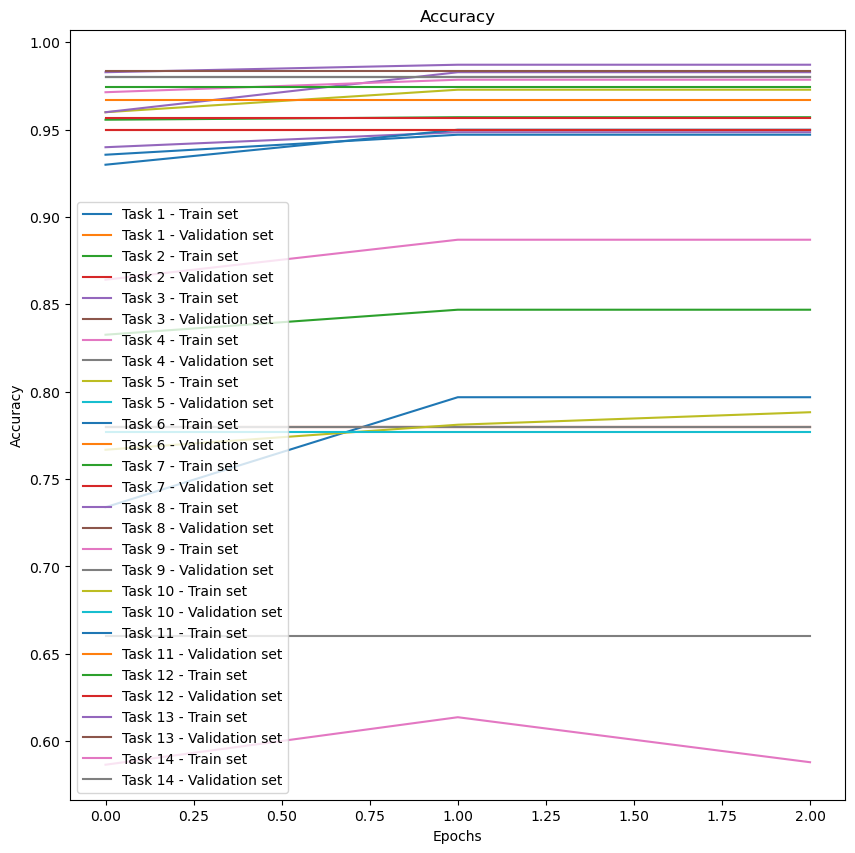

In [271]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['task_output_1_accuracy']))
plt.plot(xaxis, history.history['task_output_1_accuracy'], label='Task 1 - Train set')
plt.plot(xaxis, history.history['val_task_output_1_accuracy'], label='Task 1 - Validation set')

plt.plot(xaxis, history.history['task_output_2_accuracy'], label='Task 2 - Train set')
plt.plot(xaxis, history.history['val_task_output_1_accuracy'], label='Task 2 - Validation set')

plt.plot(xaxis, history.history['task_output_3_accuracy'], label='Task 3 - Train set')
plt.plot(xaxis, history.history['val_task_output_1_accuracy'], label='Task 3 - Validation set')

plt.plot(xaxis, history.history['task_output_4_accuracy'], label='Task 4 - Train set')
plt.plot(xaxis, history.history['val_task_output_1_accuracy'], label='Task 4 - Validation set')

plt.plot(xaxis, history.history['task_output_5_accuracy'], label='Task 5 - Train set')
plt.plot(xaxis, history.history['val_task_output_5_accuracy'], label='Task 5 - Validation set')

plt.plot(xaxis, history.history['task_output_6_accuracy'], label='Task 6 - Train set')
plt.plot(xaxis, history.history['val_task_output_6_accuracy'], label='Task 6 - Validation set')

plt.plot(xaxis, history.history['task_output_7_accuracy'], label='Task 7 - Train set')
plt.plot(xaxis, history.history['val_task_output_7_accuracy'], label='Task 7 - Validation set')


plt.plot(xaxis, history.history['task_output_8_accuracy'], label='Task 8 - Train set')
plt.plot(xaxis, history.history['val_task_output_8_accuracy'], label='Task 8 - Validation set')

plt.plot(xaxis, history.history['task_output_9_accuracy'], label='Task 9 - Train set')
plt.plot(xaxis, history.history['val_task_output_9_accuracy'], label='Task 9 - Validation set')

plt.plot(xaxis, history.history['task_output_10_accuracy'], label='Task 10 - Train set')
plt.plot(xaxis, history.history['val_task_output_10_accuracy'], label='Task 10 - Validation set')

plt.plot(xaxis, history.history['task_output_11_accuracy'], label='Task 11 - Train set')
plt.plot(xaxis, history.history['val_task_output_11_accuracy'], label='Task 11 - Validation set')

plt.plot(xaxis, history.history['task_output_12_accuracy'], label='Task 12 - Train set')
plt.plot(xaxis, history.history['val_task_output_12_accuracy'], label='Task 12 - Validation set')


plt.plot(xaxis, history.history['task_output_13_accuracy'], label='Task 13 - Train set')
plt.plot(xaxis, history.history['val_task_output_13_accuracy'], label='Task 13 - Validation set')

plt.plot(xaxis, history.history['task_output_14_accuracy'], label='Task 14 - Train set')
plt.plot(xaxis, history.history['val_task_output_14_accuracy'], label='Task 14 - Validation set')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()